## Bounding Box model

The concept and data is from this kaggle kernel: [Bounding Box Model](https://www.kaggle.com/martinpiotte/bounding-box-model)

Also from this notebook: [github](https://github.com/radekosmulski/whale/blob/master/fluke_detection_redux.ipynb)

The idea is standardize the image focus and to make it easier for the classification model to recognize whale id. The data provide by kernel was manually placing landmarks on the whale tail and using the maximum value of them to create the the cropping location. 

There are 1200 bounding box samples. The data is not from this competition but from the [playground](https://www.kaggle.com/c/whale-categorization-playground) 

TO DO:
    * Export the model so one can simply just run the model rather than train

In [2]:
import fastai
from fastai import *
from fastai.vision import *

verbose = True  # print out extra details?

# import matplotlib.patches.Path
from matplotlib.patches import Rectangle
%matplotlib inline

In [3]:
# global setting
data_fp = Path('data')
data_train = data_fp/'train'
data_playground = data_fp/'train_playground'
data_test = data_fp/'test'
crop_fp = data_fp/'cropping.txt'

In [4]:
bs = 16
num_workers = 3  # set to zero when using kaggle kernel. It crashing the kernel if not
sz = 224 ## resize images

In [3]:
# testing timeit magic
%%timeit -n 1
for i in range(100): i**2

30.4 µs ± 1.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Look into the cropping dataset

In [10]:
with open(crop_fp, 'rt') as f:
    crop_ls = [r.split(',') for r in f.read().split('\n') if len(r.split(',')) > 1]

In [11]:
crop_data = [(img, [(int(coords[i]), int(coords[i+1])) for i in range(0, len(coords), 2)]) 
                                                         for img, *coords in crop_ls]

set([len(r[1]) for r in crop_data])

{4, 5, 6, 7, 8, 9, 10, 11}

There are varying number of point pairs for each image ranging from 4 to 11 points. 

Each step converting data into the right format to use
```python
    text file: "image_filename, x1, y1, x2, x3, ... \n .....]
    crop_ls: [image_filename, x1, y1, x2, x3, ...]
    crop_data: [image_filename, [(x1, y1), (x2, y2), ..]]
```

In [12]:
crop_data[0]

('88532e70.jpg',
 [(195, 293),
  (269, 115),
  (868, 158),
  (888, 170),
  (641, 496),
  (512, 546),
  (321, 524)])

In [13]:
def get_bbox(coords):
    x, y = [x for x,_ in coords], [y for _,y in coords]
    xmin, xmax= min(x), max(x)
    ymin, ymax = min(y), max(y)
    # lower left corner, width and height
    return (xmin, ymin), xmax-xmin, ymax-ymin

def draw_bbox(box):
    return Rectangle(box[0], box[1], box[2],
                     linewidth=1, edgecolor='r', facecolor='none')

def img_bbox(data):
    img = PIL.Image.open(data_playground/data[0])
    _, ax = plt.subplots(figsize=(10,10))
    ax.imshow(img)
    ax.axis('off')
    ax.scatter([x for x,_ in data[1]], [y for _,y in data[1]], marker='o', c='r')
    ax.add_patch(draw_bbox(get_bbox(data[1])))
    ax.set_title(data[0])
    plt.show()

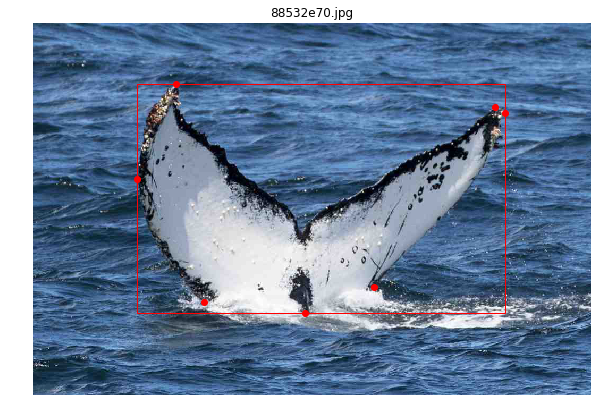

In [14]:
img_bbox(crop_data[0])

In [15]:
def get_bbox_fast(coords):
    x, y = [x for x,_ in coords], [y for _,y in coords]
    xmin, xmax= min(x), max(x)
    ymin, ymax = min(y), max(y)
    # lower left corner, width and height
    # the axes for images are inverted
    return [ymin, xmin, ymax, xmax]

In [16]:
## create a data frame
## image_fn, top, left, bottom, right
crop_dict = {key: get_bbox_fast(coords) for (key, coords) in crop_data}

## need to define a get_y function

In [17]:
crop_dict['88532e70.jpg']

[115, 195, 546, 888]

In [18]:
img = open_image(data_playground/crop_data[0][0])

In [19]:
bbox = ImageBBox.create(*img.size, [get_bbox_fast(crop_data[0][1])])

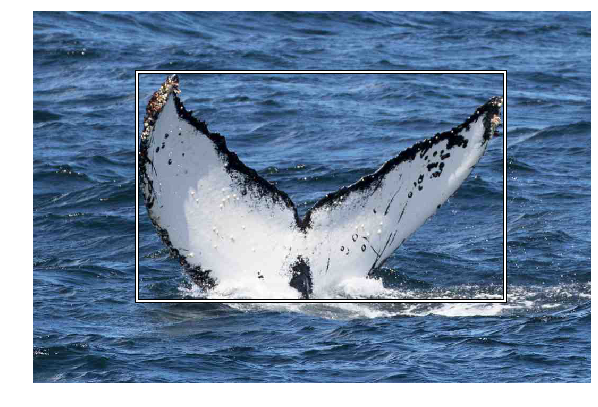

In [20]:
img.show(y=bbox, figsize=(10,10))

In [79]:
def get_y_func(fn):
    return [[crop_dict[Path(fn).name]], ['whale']]

# get_y_func = lambda o:[[crop_dict[Path(o).name]], ['whale']]

In [80]:
get_y_func('88532e70.jpg')

[[[115, 195, 546, 888]], ['whale']]

In [81]:
class StubbedObjectCategoryList(ObjectCategoryList):
    def analyze_pred(self, pred): return [pred.unsqueeze(0), torch.ones(1).long()]

In [71]:
tfms = get_transforms(flip_vert=False, max_rotate=0.3, max_zoom=1)
# tfms

In [82]:
data = (ObjectItemList.from_df(pd.DataFrame(data=list(crop_dict.keys())), path='data/train_playground')
                      .random_split_by_pct(valid_pct=0.2, seed=52)
                      .label_from_func(get_y_func, label_cls=StubbedObjectCategoryList)
                      .transform(tfms, tfm_y= True, size=sz, resize_method=ResizeMethod.SQUISH)
                      .databunch(bs=bs, collate_fn=bb_pad_collate, num_workers=num_workers)
                      .normalize(imagenet_stats))

C:\Users\boki\Anaconda3\lib\site-packages\fastai\basic_data.py:201: UserWarning: There seems to be something wrong with your dataset, can't access self.train_ds[i] for all i in [227, 498, 203, 774, 167, 99, 330, 123, 85, 217, 762, 111, 714, 705, 619, 889]
  warn(f"There seems to be something wrong with your dataset, can't access self.train_ds[i] for all i in {idx}")


You can deactivate this warning by passing `no_check=True`.


In [85]:
tmp = data.train_ds[1]

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: double, float, float16, int64, int32, and uint8.

In [83]:
data.show_batch(rows=2)

BrokenPipeError: [Errno 32] Broken pipe

In [250]:
Path('data\\train_playground\\.\\0c88a7aa.jpg').name

'0c88a7aa.jpg'

In [254]:
URLs.COCO_TINY

'http://files.fast.ai/data/examples/coco_tiny'

In [5]:
coco = untar_data(URLs.COCO_TINY)
images, lbl_bbox = get_annotations(coco/'train.json')
img2bbox = dict(zip(images, lbl_bbox))
get_y_func2 = lambda o:img2bbox[o.name]

In [24]:
coco

WindowsPath('C:/Users/boki/.fastai/data/coco_tiny')

In [6]:
data2 = (ObjectItemList.from_folder(coco)
        #Where are the images? -> in coco
        .random_split_by_pct()                          
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func2)
        #How to find the labels? -> use get_y_func
        .transform(get_transforms(), tfm_y=True)
        #Data augmentation? -> Standard transforms with tfm_y=True
        .databunch(bs=16, collate_fn=bb_pad_collate, num_workers=0))   
        #Finally we convert to a DataBunch and we use bb_pad_collate

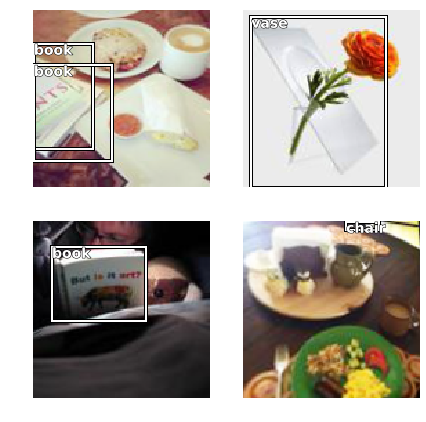

In [9]:
data2.show_batch(rows=2, figsize=(6,6))